In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys 
sys.path.append('/content/drive/MyDrive/ECE_661/661_Final_Project')

In [ ]:
# import necessary dependencies
import argparse
import os
import time
import tools
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

In [ ]:
# define the ResBlock to be used in ResNet;
class ResBlock(nn.Module):
    def __init__(self, input_dim, output_dim, k_size=3, stride_bool=False):
        super(ResBlock, self).__init__()
        if(stride_bool == True):
          self.conv1 = nn.Conv2d(input_dim, output_dim, kernel_size=k_size, stride=2, padding=1)
          self.resconv = nn.Conv2d(input_dim, output_dim, kernel_size=1, stride=2)
        else:
          self.conv1 = nn.Conv2d(input_dim, output_dim, kernel_size=k_size, padding=1)
          self.resconv = nn.Conv2d(input_dim, output_dim, kernel_size=1)

        if input_dim != output_dim:
          input_dim = output_dim
        self.bn1 = nn.BatchNorm2d(output_dim)
        self.conv2 = nn.Conv2d(input_dim, output_dim, kernel_size=k_size, padding=1)
        self.bn2 = nn.BatchNorm2d(output_dim)

    def forward(self, x):
        y = x
      # Note shortcut will just be x if of same shape as out
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out)) 
        if (x.shape == out.shape):
          out = out + y
          out = F.relu(out)
          return out
        else:
          y = self.resconv(y)
          out = out.add(y)
          out = F.relu(out)
          return out

In [ ]:
class ResNet(nn.Module):
  def __init__(self):
    super(ResNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    self.bn1 = nn.BatchNorm2d(16)
    # 16 filter res blockss
    self.res1 = ResBlock(16, 16)
    self.res2 = ResBlock(16, 16)
    self.res3 = ResBlock(16, 16)
    # Now 32 filter res blocks
    self.res4 = ResBlock(16, 32, stride_bool=True)
    self.res5 = ResBlock(32, 32)
    self.res6 = ResBlock(32, 32)
    # Now 64 filter res blocks 
    self.res7 = ResBlock(32, 64, stride_bool=True)
    self.res8 = ResBlock(64, 64)
    self.res9 = ResBlock(64, 64)

    self.fc = nn.Linear(64, 10)
    self.fc2 = nn.Linear(64,4)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))

    # ReLU contained within forward method of res blocks
    
    out = self.res1(out)
    out = self.res2(out)
    out = self.res3(out)

    out = self.res4(out)
    out = self.res5(out)
    out = self.res6(out)

    out = self.res7(out)
    out = self.res8(out)
    out = self.res9(out)

    out = F.adaptive_avg_pool2d(out, 1)
    out = out.view(out.size(0), -1)
    outt = self.fc(out)
    outr = self.fc2(out)
    # out = F.softmax(out)
    return outt, outr

In [ ]:
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride = 1, padding = 1) # I am not sure about this output, should it be 32 or 3? Also coudln't I just use identities by forcing 
        self.conv1_bn = nn.BatchNorm2d(16)

        #starting first section of 6 - feature map 32, channel (features) 16
        self.conv2 = nn.Conv2d(16,16,3, stride = 1, padding = 1)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16,16,3, padding = 1)
        self.conv3_bn = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(16,16,3, padding = 1)
        self.conv4_bn = nn.BatchNorm2d(16)
        self.conv5 = nn.Conv2d(16,16,3, padding = 1)
        self.conv5_bn = nn.BatchNorm2d(16)
        self.conv6 = nn.Conv2d(16,16,3, padding = 1)
        self.conv6_bn = nn.BatchNorm2d(16)
        self.conv7 = nn.Conv2d(16,16,3, padding = 1) #it would be here that I need a 1x1 convolution on my bypass that gets fed to lower stuff 
        self.conv7_bn = nn.BatchNorm2d(16)
        self.bp4_conv = nn.Conv2d(16,32,1, stride = 2)
        self.bp4_bn = nn.BatchNorm2d(32) 

        

        #Now starting second section of 6 - now feature map 16, channel (features) 32
        self.conv8 = nn.Conv2d(16,32,3, stride = 2, padding = 1) # HERE COULD BE AN ISSUE - I AM NOT SURE IF I SHOULD PAD OR NOT 
        self.conv8_bn = nn.BatchNorm2d(32) 
        self.conv9 = nn.Conv2d(32,32,3, padding = 1)
        self.conv9_bn = nn.BatchNorm2d(32) 
        self.conv10 = nn.Conv2d(32,32,3, padding = 1)
        self.conv10_bn = nn.BatchNorm2d(32) 
        self.conv11 = nn.Conv2d(32,32,3, padding = 1)
        self.conv11_bn = nn.BatchNorm2d(32) 
        self.conv12 = nn.Conv2d(32,32,3, padding = 1)
        self.conv12_bn = nn.BatchNorm2d(32) 
        self.conv13 = nn.Conv2d(32,32,3, padding = 1) # need 1x1 conv here on bypass that gets fed to lower stuff 
        self.conv13_bn = nn.BatchNorm2d(32)
        self.bp7_conv = nn.Conv2d(32,64,1, stride = 2)
        self.bp7_bn = nn.BatchNorm2d(64) 

        # now starting third section of 6 - feature map is 8, channel (features) 64 (8x8x64)
        self.conv14 = nn.Conv2d(32,64,3, stride = 2, padding = 1) # SAME THING MAYBE I NEED TO PADD MAYBE I DON'T NEED TO 
        self.conv14_bn = nn.BatchNorm2d(64) 
        self.conv15 = nn.Conv2d(64,64,3, stride = 1, padding = 1)
        self.conv15_bn = nn.BatchNorm2d(64) 
        self.conv16 = nn.Conv2d(64,64,3, stride = 1, padding = 1)
        self.conv16_bn = nn.BatchNorm2d(64) 
        self.conv17 = nn.Conv2d(64,64,3, stride = 1, padding = 1)
        self.conv17_bn = nn.BatchNorm2d(64) 
        self.conv18 = nn.Conv2d(64,64,3, stride = 1, padding = 1)
        self.conv18_bn = nn.BatchNorm2d(64) 
        self.conv19 = nn.Conv2d(64,64,3, stride = 1, padding = 1)
        self.conv19_bn = nn.BatchNorm2d(64)  
       

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1   = nn.Linear(64,10)
        self.fc2 = nn.Linear(64,4) 

    # THIS IS WHERE I need to fit it all together and worry about my residual stuff 
    def forward(self, x):
        out = F.relu(self.conv1_bn(self.conv1(x))) # this is okay, goes after conv and before activation functionp

        bp1 = out # SAVE THE BYPASS DATA HERE, MAYBE COPY? Maybe not 
      
        out = F.relu(self.conv2_bn(self.conv2(out)))

        out = self.conv3_bn(self.conv3(out))
  
        # IN here I need to add the first bypass data to the current out, then I feed it to the next guy - need to think a little about when I need to do the convolution on the BP
        out = bp1 + out #This totally works! Very chill and cool of pytorch lol
        out = F.relu(out)
        bp2 = out # maybe copy, maybe not, we'll see 
        out  = F.relu(self.conv4_bn(self.conv4(out)))
        out = self.conv5_bn(self.conv5(out))
        out = bp2 + out
        out = F.relu(out)
        bp3 = out
        out = F.relu(self.conv6_bn(self.conv6(out)))
        out = self.conv7_bn(self.conv7(out))
        out = out + bp3
        out = F.relu(out)
        bp4 = out
        bp4_ready = self.bp4_bn(self.bp4_conv(bp4))
        out = F.relu(self.conv8_bn(self.conv8(out)))
        out = self.conv9_bn(self.conv9(out))
        out = bp4_ready+out
        out = F.relu(out)
        bp5 = out
        out = F.relu(self.conv10_bn(self.conv10(out)))
        out = self.conv11_bn(self.conv11(out))
        out = out + bp5
        out = F.relu(out)
        bp6 = out
        out = F.relu(self.conv12_bn(self.conv12(out)))
        out = self.conv13_bn(self.conv13(out))
        out = out + bp6
        out = F.relu(out)
        bp7 = out
        bp7_ready = self.bp7_bn(self.bp7_conv(out))
        out = F.relu(self.conv14_bn(self.conv14(out)))
        out = self.conv15_bn(self.conv15(out))
        out = bp7_ready+out
        out = F.relu(out)
        bp8 = out
        out = F.relu(self.conv16_bn(self.conv16(out)))
        out = self.conv17_bn(self.conv17(out))
        out = out + bp8
        out = F.relu(out)
        bp9 = out
        out = F.relu(self.conv18_bn(self.conv18(out)))
        out = self.conv19_bn(self.conv19(out))
        out = out + bp9
        out = F.relu(out)
        out = self.avg_pool(out)


        out = out.view(out.size(0), -1) # IF THIS BREAKS THEN CHECK HERE, Might need it might not
        #avg pooling here
        #fully connected here
        outt = self.fc1(out)
        outr = self.fc2(out)
        return outt, outr

**Importing Corruptions**

In [ ]:
import numpy as np
import math
from PIL import Image
import skimage as sk
from skimage.filters import gaussian
from io import BytesIO
import cv2
from scipy.ndimage import zoom as scizoom
from scipy.ndimage.interpolation import map_coordinates
import warnings
import os
from pkg_resources import resource_filename
from numba import njit, prange

#### These are all helper Functions ###

def disk(radius, alias_blur=0.1, dtype=np.float32):
    if radius <= 8:
        L = np.arange(-8, 8 + 1)
        ksize = (3, 3)
    else:
        L = np.arange(-radius, radius + 1)
        ksize = (5, 5)
    X, Y = np.meshgrid(L, L)
    aliased_disk = np.array((X ** 2 + Y ** 2) <= radius ** 2, dtype=dtype)
    aliased_disk /= np.sum(aliased_disk)

    # supersample disk to antialias
    return cv2.GaussianBlur(aliased_disk, ksize=ksize, sigmaX=alias_blur)


def next_power_of_2(x):
    return 1 if x == 0 else 2 ** (x - 1).bit_length()

# modification of https://github.com/FLHerne/mapgen/blob/master/diamondsquare.py
def plasma_fractal(mapsize=256, wibbledecay=3):
    """
    Generate a heightmap using diamond-square algorithm.
    Return square 2d array, side length 'mapsize', of floats in range 0-255.
    'mapsize' must be a power of two.
    """
    assert (mapsize & (mapsize - 1) == 0)
    maparray = np.empty((mapsize, mapsize), dtype=np.float_)
    maparray[0, 0] = 0
    stepsize = mapsize
    wibble = 100

    def wibbledmean(array):
        return array / 4 + wibble * np.random.uniform(-wibble, wibble,
                                                      array.shape)

    def fillsquares():
        """For each square of points stepsize apart,
           calculate middle value as mean of points + wibble"""
        cornerref = maparray[0:mapsize:stepsize, 0:mapsize:stepsize]
        squareaccum = cornerref + np.roll(cornerref, shift=-1, axis=0)
        squareaccum += np.roll(squareaccum, shift=-1, axis=1)
        maparray[stepsize // 2:mapsize:stepsize,
        stepsize // 2:mapsize:stepsize] = wibbledmean(squareaccum)

    def filldiamonds():
        """For each diamond of points stepsize apart,
           calculate middle value as mean of points + wibble"""
        mapsize = maparray.shape[0]
        drgrid = maparray[stepsize // 2:mapsize:stepsize,
                 stepsize // 2:mapsize:stepsize]
        ulgrid = maparray[0:mapsize:stepsize, 0:mapsize:stepsize]
        ldrsum = drgrid + np.roll(drgrid, 1, axis=0)
        lulsum = ulgrid + np.roll(ulgrid, -1, axis=1)
        ltsum = ldrsum + lulsum
        maparray[0:mapsize:stepsize,
        stepsize // 2:mapsize:stepsize] = wibbledmean(ltsum)
        tdrsum = drgrid + np.roll(drgrid, 1, axis=1)
        tulsum = ulgrid + np.roll(ulgrid, -1, axis=0)
        ttsum = tdrsum + tulsum
        maparray[stepsize // 2:mapsize:stepsize,
        0:mapsize:stepsize] = wibbledmean(ttsum)

    while stepsize >= 2:
        fillsquares()
        filldiamonds()
        stepsize //= 2
        wibble /= wibbledecay

    maparray -= maparray.min()
    return maparray / maparray.max()


def clipped_zoom(img, zoom_factor):
    # clipping along the width dimension:
    ch0 = int(np.ceil(img.shape[0] / float(zoom_factor)))
    top0 = (img.shape[0] - ch0) // 2

    # clipping along the height dimension:
    ch1 = int(np.ceil(img.shape[1] / float(zoom_factor)))
    top1 = (img.shape[1] - ch1) // 2

    img = scizoom(img[top0:top0 + ch0, top1:top1 + ch1],
                  (zoom_factor, zoom_factor, 1), order=1)

    return img

def getOptimalKernelWidth1D(radius, sigma):
    return radius * 2 + 1

def gauss_function(x, mean, sigma):
    return (np.exp(- (x - mean)**2 / (2 * (sigma**2)))) / (np.sqrt(2 * np.pi) * sigma)

def getMotionBlurKernel(width, sigma):
    k = gauss_function(np.arange(width), 0, sigma)
    Z = np.sum(k)
    return k/Z

def shift(image, dx, dy):
    if(dx < 0):
        shifted = np.roll(image, shift=image.shape[1]+dx, axis=1)
        shifted[:,dx:] = shifted[:,dx-1:dx]
    elif(dx > 0):
        shifted = np.roll(image, shift=dx, axis=1)
        shifted[:,:dx] = shifted[:,dx:dx+1]
    else:
        shifted = image

    if(dy < 0):
        shifted = np.roll(shifted, shift=image.shape[0]+dy, axis=0)
        shifted[dy:,:] = shifted[dy-1:dy,:]
    elif(dy > 0):
        shifted = np.roll(shifted, shift=dy, axis=0)
        shifted[:dy,:] = shifted[dy:dy+1,:]
    return shifted

def _motion_blur(x, radius, sigma, angle):
    width = getOptimalKernelWidth1D(radius, sigma)
    kernel = getMotionBlurKernel(width, sigma)
    point = (width * np.sin(np.deg2rad(angle)), width * np.cos(np.deg2rad(angle)))
    hypot = math.hypot(point[0], point[1])

    blurred = np.zeros_like(x, dtype=np.float32)
    for i in range(width):
        dy = -math.ceil(((i*point[0]) / hypot) - 0.5)
        dx = -math.ceil(((i*point[1]) / hypot) - 0.5)
        if (np.abs(dy) >= x.shape[0] or np.abs(dx) >= x.shape[1]):
            # simulated motion exceeded image borders
            break
        shifted = shift(x, dx, dy)
        blurred = blurred + kernel[i] * shifted
    return blurred

# Numba nopython compilation to shuffle_pixles
@njit()
def _shuffle_pixels_njit_glass_blur(d0,d1,x,c):

    # locally shuffle pixels
    for i in range(c[2]):
        for h in range(d0 - c[1], c[1], -1):
            for w in range(d1 - c[1], c[1], -1):
                dx, dy = np.random.randint(-c[1], c[1], size=(2,))
                h_prime, w_prime = h + dy, w + dx
                # swap
                x[h, w], x[h_prime, w_prime] = x[h_prime, w_prime], x[h, w]
    return x



### THESE ARE THE ACTUAL CORRUPTIONS ###
def contrast(x, severity=1):
    c = [0.4, .3, .2, .1, .05][severity - 1]

    x = np.array(x) / 255.
    means = np.mean(x, axis=(0, 1), keepdims=True)
    return np.clip((x - means) * c + means, 0, 1) * 255

def gaussian_blur(x, severity=1):
    c = [1, 2, 3, 4, 6][severity - 1]

    x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
    return np.clip(x, 0, 1) * 255  

def pixelate(x, severity=1):
    c = [0.6, 0.5, 0.4, 0.3, 0.25][severity - 1]

    x_shape = np.array(x).shape

    x = x.resize((int(x_shape[1] * c), int(x_shape[0] * c)), Image.BOX)

    x = x.resize((x_shape[1], x_shape[0]), Image.NEAREST)

    return x

def fog(x, severity=1):
    c = [(1.5, 2), (2., 2), (2.5, 1.7), (2.5, 1.5), (3., 1.4)][severity - 1]

    shape = np.array(x).shape
    max_side = np.max(shape)
    map_size = next_power_of_2(int(max_side))

    x = np.array(x) / 255.
    max_val = x.max()

    x_shape = np.array(x).shape
    if len(x_shape) < 3 or x_shape[2] < 3:
        x += c[0] * plasma_fractal(mapsize=map_size, wibbledecay=c[1])[
                    :shape[0], :shape[1]]
    else:
        x += c[0] * \
             plasma_fractal(mapsize=map_size, wibbledecay=c[1])[:shape[0],
             :shape[1]][..., np.newaxis]
    return np.clip(x * max_val / (max_val + c[0]), 0, 1) * 255



def motion_blur(x, severity=1):
    shape = np.array(x).shape
    c = [(10, 3), (15, 5), (15, 8), (15, 12), (20, 15)][severity - 1]
    x = np.array(x)

    angle = np.random.uniform(-45, 45)
    x = _motion_blur(x, radius=c[0], sigma=c[1], angle=angle)

    if len(x.shape) < 3 or x.shape[2] < 3:
        gray = np.clip(np.array(x).transpose((0, 1)), 0, 255)
        if len(shape) >= 3 or shape[2] >=3:
            return np.stack([gray, gray, gray], axis=2)
        else:
            return gray
    else:
        return np.clip(x, 0, 255)


def defocus_blur(x, severity=1):
    c = [(3, 0.1), (4, 0.5), (6, 0.5), (8, 0.5), (10, 0.5)][severity - 1]

    x = np.array(x) / 255.
    kernel = disk(radius=c[0], alias_blur=c[1])

    channels = []
    if len(x.shape) < 3 or x.shape[2] < 3:
        channels = np.array(cv2.filter2D(x, -1, kernel))
    else:
        for d in range(3):
            channels.append(cv2.filter2D(x[:, :, d], -1, kernel))
        channels = np.array(channels).transpose((1, 2, 0))

    return np.clip(channels, 0, 1) * 255

In [ ]:
# do NOT change these
#import tools
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 256
VAL_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset
test_set = CIFAR10(
    root=DATA_ROOT, 
    mode='test', 
    download=True,
)


test_loader = DataLoader(
    test_set, 
    batch_size=256,  # your code
    shuffle=False,     # your code
    num_workers=4
)
#############################################

0it [00:00, ?it/s]

Extracting ./data/cifar10_test_F22.zip to ./data
Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
test_labels = np.asarray(np.load('/content/drive/MyDrive/ECE_661/661_Final_Project/tools/test-labels-batch.npy'))

In [ ]:
import shutil
from PIL import Image
from torch.utils.data import Dataset as VisionDataset
from tools.utils import check_integrity, download_and_extract_archive
import torchvision
import torchvision.transforms as transforms
#############################################
# your code here
# construct dataset
transform_val = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))])

test_set = CIFAR10(
    root=DATA_ROOT, 
    mode='test', 
    download=True,
    transform=transform_val
)


test_loader = DataLoader(
    test_set, 
    batch_size=256,  # your code
    shuffle=False,     # your code
    num_workers=4
)
#############################################

Using downloaded and verified file: ./data/cifar10_test_F22.zip
Extracting ./data/cifar10_test_F22.zip to ./data
Files already downloaded and verified


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")
  


Run on GPU...


In [ ]:
def gaussian_noise(x, severity=1):
    c = [.08, .12, 0.18, 0.26, 0.38][severity - 1]

    x = np.array(x) / 255.
    return np.clip(x + np.random.normal(size=x.shape, scale=c), 0, 1) * 255

def glass_blur(x, severity=1):
    # sigma, max_delta, iterations
    c = [(0.7, 1, 2), (0.9, 2, 1), (1, 2, 3), (1.1, 3, 2), (1.5, 4, 2)][
        severity - 1]

    x = np.uint8(
        gaussian(np.array(x) / 255., sigma=c[0], multichannel=True) * 255)

    x = _shuffle_pixels_njit_glass_blur(np.array(x).shape[0],np.array(x).shape[1],x,c)

    return np.clip(gaussian(x / 255., sigma=c[0], multichannel=True), 0,
                   1) * 255


def motion_blur(x, severity=1):
    shape = np.array(x).shape
    c = [(10, 3), (15, 5), (15, 8), (15, 12), (20, 15)][severity - 1]
    x = np.array(x)

    angle = np.random.uniform(-45, 45)
    x = _motion_blur(x, radius=c[0], sigma=c[1], angle=angle)

    if len(x.shape) < 3 or x.shape[2] < 3:
        gray = np.clip(np.array(x).transpose((0, 1)), 0, 255)
        if len(shape) >= 3 or shape[2] >=3:
            return np.stack([gray, gray, gray], axis=2)
        else:
            return gray
    else:
        return np.clip(x, 0, 255)




def speckle_noise(x, severity=1):
    c = [.15, .2, 0.35, 0.45, 0.6][severity - 1]

    x = np.array(x) / 255.
    return np.clip(x + x * np.random.normal(size=x.shape, scale=c), 0, 1) * 255

In [ ]:
###Now making 5 diff test nets for the 5 corruptions###

def test_net_speckle_noise(net, dataloader, batch_size, severity = 1):
  correct = 0
  total = 10000
  i = 0
  size_total=0
  for x in dataloader:
    x_evil = speckle_noise(x, severity)
    x_evil = torch.FloatTensor(x_evil)
    x_evil = x_evil.to(device)
    out = net(x_evil)[0]
    size_total += out.size()[0]
    targets = torch.Tensor(test_labels[i:i+batch_size]).to(device)
    i += batch_size

    _, predicted = torch.max(out, 1)
    correct += predicted.eq(targets).sum()
  # print(size_total)
  # print(correct)
  return correct / total


def test_net_motion_blur(net, dataloader, batch_size, severity = 1):
  correct = 0
  total = 10000
  i = 0
  size_total=0
  for x in dataloader:
    x_evil = motion_blur(x, severity)
    x_evil = torch.FloatTensor(x_evil)
    x_evil = x_evil.to(device)
    out = net(x_evil)[0]
    size_total += out.size()[0]
    targets = torch.Tensor(test_labels[i:i+batch_size]).to(device)
    i += batch_size

    _, predicted = torch.max(out, 1)
    correct += predicted.eq(targets).sum()
  # print(size_total)
  # print(correct)
  return correct / total


def test_net_glass_blur(net, dataloader, batch_size, severity = 1):
    correct = 0
    total = 10000
    i = 0
    size_total=0
    for x in dataloader:
      x_evil = glass_blur(x, severity)
      x_evil = torch.FloatTensor(x_evil)
      x_evil = x_evil.to(device)
      out = net(x_evil)[0]
      size_total += out.size()[0]
      targets = torch.Tensor(test_labels[i:i+batch_size]).to(device)
      i += batch_size

      _, predicted = torch.max(out, 1)
      correct += predicted.eq(targets).sum()
    # print(size_total)
    # print(correct)
    return correct / total


def test_net_gaussian_noise(net, dataloader, batch_size, severity = 1):
  correct = 0
  total = 10000
  i = 0
  size_total=0
  for x in dataloader:
    x_evil = gaussian_noise(x, severity)
    x_evil = torch.FloatTensor(x_evil)
    x_evil = x_evil.to(device)
    out = net(x_evil)[0]
    size_total += out.size()[0]
    targets = torch.Tensor(test_labels[i:i+batch_size]).to(device)
    i += batch_size

    _, predicted = torch.max(out, 1)
    correct += predicted.eq(targets).sum()
  # print(size_total)
  # print(correct)
  return correct / total


def test_net_gaussian_blur(net, dataloader, batch_size, severity = 1):
  correct = 0
  total = 10000
  i = 0
  size_total=0
  for x in dataloader:
    x_evil = gaussian_blur(x, severity)
    x_evil = torch.FloatTensor(x_evil)
    x_evil = x_evil.to(device)
    out = net(x_evil)[0]
    size_total += out.size()[0]
    targets = torch.Tensor(test_labels[i:i+batch_size]).to(device)
    i += batch_size

    _, predicted = torch.max(out, 1)
    correct += predicted.eq(targets).sum()
  # print(size_total)
  # print(correct)
  return correct / total


def test_net(net, dataloader, batch_size):
  correct = 0
  total = 10000
  size_total = 0
  i = 0
  for x in dataloader:
    x = x.to(device)
    out = net(x)[0]
    size_total += out.size()[0]
    targets = torch.Tensor(test_labels[i:i+batch_size]).to(device)
    i += batch_size

    _, predicted = torch.max(out, 1)
    correct += predicted.eq(targets).sum()
  # print(size_total)
  # print(correct)
  return correct / total

**Creating model and bar chart for corruption**

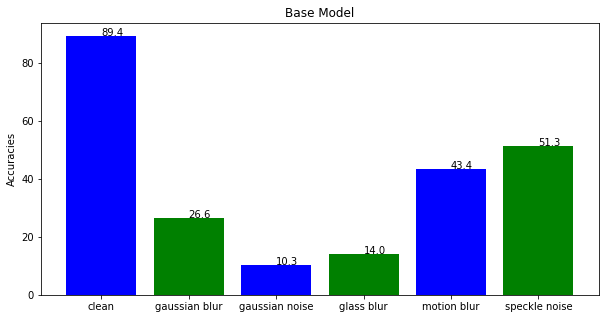

In [ ]:
### need to change to resnet with a capital N  for the other ones##
# importing library
import matplotlib.pyplot as plt
  
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

net = ResNet().to(device)
state_dict = torch.load("/content/drive/MyDrive/ECE_661/661_Final_Project/resnet_base.pth")
net.load_state_dict(state_dict["state_dict"])


corrupted_acc = [round(test_net(net, test_loader, 256).item()*100, 1), round(test_net_gaussian_blur(net, test_loader, 256, 1).item()*100,1), round(test_net_gaussian_noise(net, test_loader, 256, 1).item()*100,1) , round(test_net_glass_blur(net, test_loader, 256, 1).item()*100, 1), round(test_net_motion_blur(net, test_loader, 256, 1).item()*100,1), round(test_net_speckle_noise(net, test_loader, 256, 1).item()*100,1)]

x = ['clean', 'gaussian blur', 'gaussian noise', 'glass blur', 'motion blur', 'speckle noise']

plt.figure(figsize = (10, 5))


plt.bar(x, corrupted_acc, color=['blue', 'green', 'blue', 'green', 'blue', 'green'])




# calling the function to add value labels
addlabels(x, corrupted_acc)
      
    # giving title to the plot
plt.title("Base Model")
      
# giving X and Y labels
plt.ylabel("Accuracies")
      
    # visualizing the plot
plt.show()

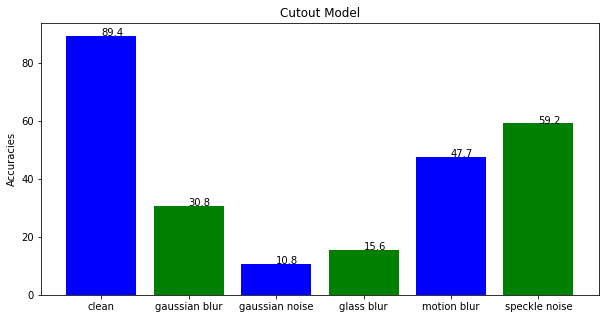

In [ ]:
### need to change to resnet with a capital N  for the other ones##
# importing library
import matplotlib.pyplot as plt
  
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

net = ResNet().to(device)
state_dict = torch.load("/content/drive/MyDrive/ECE_661/661_Final_Project/resnet_cutout.pth")
net.load_state_dict(state_dict["state_dict"])


corrupted_acc = [round(test_net(net, test_loader, 256).item()*100, 1), round(test_net_gaussian_blur(net, test_loader, 256, 1).item()*100,1), round(test_net_gaussian_noise(net, test_loader, 256, 1).item()*100,1) , round(test_net_glass_blur(net, test_loader, 256, 1).item()*100, 1), round(test_net_motion_blur(net, test_loader, 256, 1).item()*100,1), round(test_net_speckle_noise(net, test_loader, 256, 1).item()*100,1)]

x = ['clean', 'gaussian blur', 'gaussian noise', 'glass blur', 'motion blur', 'speckle noise']

plt.figure(figsize = (10, 5))


plt.bar(x, corrupted_acc, color=['blue', 'green', 'blue', 'green', 'blue', 'green'])




# calling the function to add value labels
addlabels(x, corrupted_acc)
      
    # giving title to the plot
plt.title("Cutout Model")
      
# giving X and Y labels
plt.ylabel("Accuracies")
      
    # visualizing the plot
plt.show()

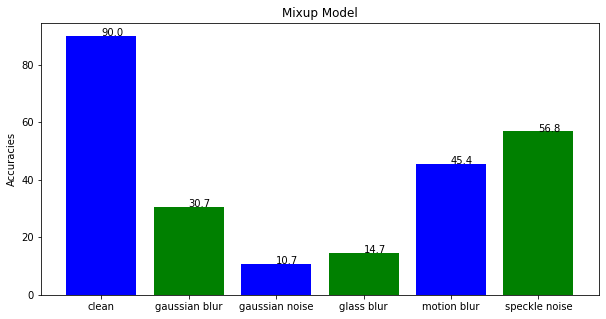

In [ ]:
### need to change to resnet with a capital N  for the other ones##
# importing library
import matplotlib.pyplot as plt
  
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

net = ResNet().to(device)
state_dict = torch.load("/content/drive/MyDrive/ECE_661/661_Final_Project/resnet_mixup.pth")
net.load_state_dict(state_dict["state_dict"])


corrupted_acc = [round(test_net(net, test_loader, 256).item()*100, 1), round(test_net_gaussian_blur(net, test_loader, 256, 1).item()*100,1), round(test_net_gaussian_noise(net, test_loader, 256, 1).item()*100,1) , round(test_net_glass_blur(net, test_loader, 256, 1).item()*100, 1), round(test_net_motion_blur(net, test_loader, 256, 1).item()*100,1), round(test_net_speckle_noise(net, test_loader, 256, 1).item()*100,1)]

x = ['clean', 'gaussian blur', 'gaussian noise', 'glass blur', 'motion blur', 'speckle noise']

plt.figure(figsize = (10, 5))


plt.bar(x, corrupted_acc, color=['blue', 'green', 'blue', 'green', 'blue', 'green'])




# calling the function to add value labels
addlabels(x, corrupted_acc)
      
    # giving title to the plot
plt.title("Mixup Model")
      
# giving X and Y labels
plt.ylabel("Accuracies")
      
    # visualizing the plot
plt.show()

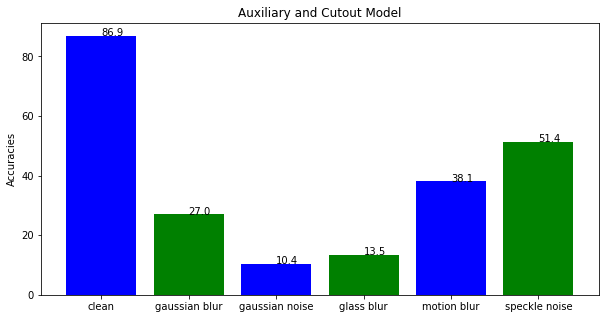

In [ ]:
### need to change to resnet with a capital N  for the other ones##
# importing library
import matplotlib.pyplot as plt
  
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

net = ResNet().to(device)
state_dict = torch.load("/content/drive/MyDrive/ECE_661/661_Final_Project/resnet_aux_cutout.pth")
net.load_state_dict(state_dict["state_dict"])


corrupted_acc = [round(test_net(net, test_loader, 256).item()*100, 1), round(test_net_gaussian_blur(net, test_loader, 256, 1).item()*100,1), round(test_net_gaussian_noise(net, test_loader, 256, 1).item()*100,1) , round(test_net_glass_blur(net, test_loader, 256, 1).item()*100, 1), round(test_net_motion_blur(net, test_loader, 256, 1).item()*100,1), round(test_net_speckle_noise(net, test_loader, 256, 1).item()*100,1)]

x = ['clean', 'gaussian blur', 'gaussian noise', 'glass blur', 'motion blur', 'speckle noise']

plt.figure(figsize = (10, 5))


plt.bar(x, corrupted_acc, color=['blue', 'green', 'blue', 'green', 'blue', 'green'])




# calling the function to add value labels
addlabels(x, corrupted_acc)
      
    # giving title to the plot
plt.title("Auxiliary and Cutout Model")
      
# giving X and Y labels
plt.ylabel("Accuracies")
      
    # visualizing the plot
plt.show()

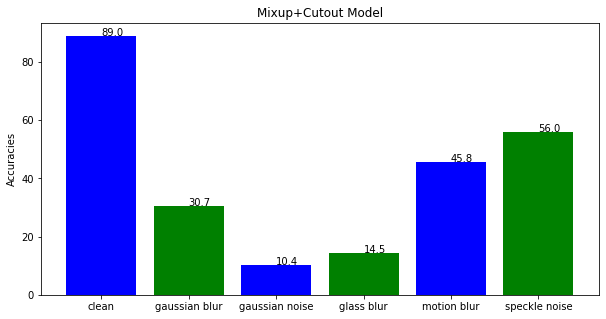

In [ ]:
### need to change to resnet with a capital N  for the other ones##
# importing library
import matplotlib.pyplot as plt
  
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

net = ResNet().to(device)
state_dict = torch.load("/content/drive/MyDrive/ECE_661/661_Final_Project/resnet_mixup_cutout.pth")
net.load_state_dict(state_dict["state_dict"])


corrupted_acc = [round(test_net(net, test_loader, 256).item()*100, 1), round(test_net_gaussian_blur(net, test_loader, 256, 1).item()*100,1), round(test_net_gaussian_noise(net, test_loader, 256, 1).item()*100,1) , round(test_net_glass_blur(net, test_loader, 256, 1).item()*100, 1), round(test_net_motion_blur(net, test_loader, 256, 1).item()*100,1), round(test_net_speckle_noise(net, test_loader, 256, 1).item()*100,1)]

x = ['clean', 'gaussian blur', 'gaussian noise', 'glass blur', 'motion blur', 'speckle noise']

plt.figure(figsize = (10, 5))


plt.bar(x, corrupted_acc, color=['blue', 'green', 'blue', 'green', 'blue', 'green'])




# calling the function to add value labels
addlabels(x, corrupted_acc)
      
    # giving title to the plot
plt.title("Mixup+Cutout Model")
      
# giving X and Y labels
plt.ylabel("Accuracies")
      
    # visualizing the plot
plt.show()